In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys


### 데이터 불러오고 확인하기

In [4]:
print(y)
y = y.astype(np.int)
print(y)
print(X.shape)
print(y.shape)

['5' '0' '4' ... '4' '5' '6']
[5 0 4 ... 4 5 6]
(70000, 784)
(70000,)


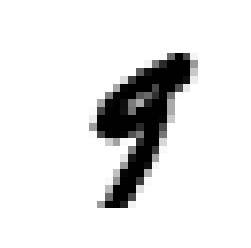

9

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
y[36000]

MNIST 자료는 이미 훈련 데이터와 테스트 데이터가 분리되어 있다.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

트레이닝 셋을 미리 섞어주자.

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 이진 분류기 만들기~

### SGD를 이용해 5를 식별하는 분류기를 만들어보자.

In [7]:
# 타깃 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=15, tol = 1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

### 분류기 성능 측정

In [70]:
from sklearn.model_selection import cross_val_score

# 3-fold 교차 검증. sgd_clf 성능을 판단한다. 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96685, 0.9501 , 0.9507 ])

위 결과를 무조건 5로 추론하는 분류기 성능과 비교해보자.

In [113]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.90765, 0.91015, 0.91115])

### Confusion Matrix 만들기

In [115]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict는 cross_val_score와 비슷하다. 
# X_train을 3 세트로 나누고, 두 세트로 훈련하여 나머지 한 세트의 예측을 내놓는다.
# 다만 3세트에 대한 예측의 정확도를 산출하지 않고, 예측한 True, False값을 그대로 산출한다.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False,  True, ..., False, False, False])

In [119]:
from sklearn.metrics import confusion_matrix

# (실제값, 예측값)을 넣어준다.
confusion_matrix(y_train_5, y_train_pred)

array([[53439,  1140],
       [ 1507,  3914]], dtype=int64)

### 정밀도(precision)와 재현율(recall) 계산하기

In [120]:
from sklearn.metrics import precision_score, recall_score

# (실제값, 예측값)을 넣어준다.
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7744360902255639
0.722007009776794


보다시피, 5라고 예측하면 그 중 77%가 맞고, 전체 5 중에서 72%만 감지했다. 이 둘의 조화평균을 F1 score라고 한다. <br>
F1 점수는 높을수록 좋으며, 최대가 1이다.

In [121]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7473031026252983

desicion_function() 매서드를 통해 각 데이터의 확실성을 수치로 볼 수 있다. <br>이 값이 일정 정도(초기값 0)를 넘기면 True를 반환하는 방식이다.

In [122]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-170163.53083105])

In [123]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # True Negetive

array([False])

In [124]:
threshold = -200000 # precision이 내려간다.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # False Positive

array([ True])

threshold에 대한 precision과 recall의 함수를 그래프로 그려보자

In [125]:
# cross_val_predict에 method="decision_function" 옵션을 주면, 
# 각 데이터에 대한 True/False를 반환하는 대신,
# 각 데이터에 대한 decision_function 값을 산출한다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                           method="decision_function")
y_scores.shape

(60000,)

In [145]:
from sklearn.metrics import precision_recall_curve

# 임계값 별로 정밀도와 재현율을 계산해서 산출해준다.
# decision score가 동일한 경우도 있어서, 임계값의 갯수가 데이터 갯수와 일치하지는 않는다.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions.shape)
print(recalls.shape)
print(thresholds.shape)

(59776,)
(59776,)
(59775,)


In [128]:
# 5가 아니라고 답하는 비율이 일정 이상 올라가면 정밀도가 1이 된다.
# 그러나 모두 5가 아니라고 답하는 경우, 정밀도를 계산할 수 없기 때문에 precisions[-1]에는 1을 넣어서 반환한다.
# recalls[-1]의 경우에도 일관성 때문인지 0을 넣어서 반환한다.
print(precisions[-1], precisions[-3])
print(recalls[-1])

# 모두 5라고 답하는 분류기의 경우 재현율이 1이다.
# 정밀도는 5의 비율만큼이다.

print(recalls[0])
print(precisions[0])

1.0 1.0
0.0
1.0
0.09068857066381156


In [129]:
thresholds[0]

-885094.2769333419

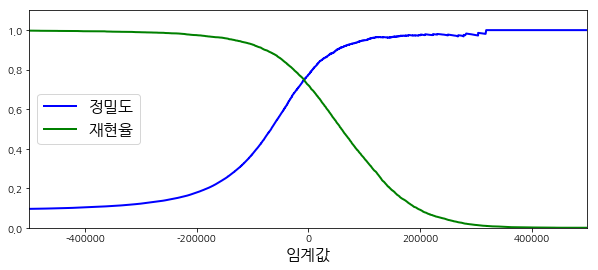

In [135]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc=6, fontsize=16)
    plt.ylim([0, 1.1])

plt.figure(figsize=(10, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-500000, 500000])
plt.show()

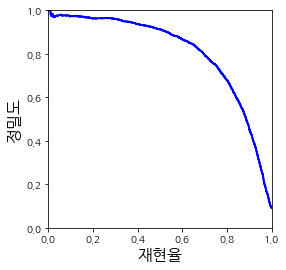

In [138]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(4, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [139]:
# 원하는 임계값으로 이진분류기를 만들려면, 다음 방법을 사용한다. 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                           method="decision_function")
y_train_pred_90 = (y_scores > 70000)

In [142]:
precision_score(y_train_5, y_train_pred_90)

0.9242761692650334

In [143]:
recall_score(y_train_5, y_train_pred_90)

0.45932484781405647

### ROC Curve
수신기 조작 특성 receiver operating characteristic curve

용어정리 <br>
진짜 양성 비율(TPR) == 재현율(recall) == 민감도(sensitivity) : 타겟을 얼마나 걸러낼 수 있는가 <br>
거짓 양성 비율(FPR) == 1 - 진짜 음성 비율(TNR == 특이도, specificity) 

In [157]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
print(fpr.shape)
print(tpr.shape)
print(thresholds.shape)

(3976,)
(3976,)
(3976,)


In [161]:
print(tpr[0])
print(tpr[-1])

0.0
1.0


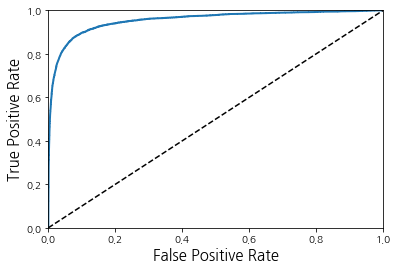

In [167]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) # xmin, ymin, xmax, ymax
    
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plot_roc_curve(fpr, tpr)
plt.show()

# 점선은 랜덤으로 분류하는 경우의 ROC 곡선이다. 점선 밑에 점이 있다면, 그건 랜덤보다 못한 분류라는 뜻이다.

위 그래프 아래 면적으로 분류기의 성능을 평가할 수 있다. <br>그 면적을 AUC(area under the curve)라 부른다. <br>

In [168]:
# AUC 구하는 방법
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9552586184522651

## 다중 분류기

이제 5를 분류하는 문제에서 0 ~ 9의 숫자를 분류하는 문제를 풀어보자. <br>
다중 분류를 푸는 방법 중 하나는 이진 분류기를 여러 개 만드는 것이다. <br>
이중분류기로 다중분류기를 만드는 방법에는 OvO 방식과 OvA 방식이 있다. SGDClassifier는 기본값이 OvA로 되어있다.

In [19]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=100, tol=10, random_state=42)
sgd_clf.fit(X_train, y_train) # y값에 따라 자동으로 다중분류 실행
sgd_clf.predict([some_digit])

array([9])

In [20]:
# OvA 방식이므로 하나의 샘플에 10개의 decision_score를 계산한다.
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[ -66158.2201632 ,  -86313.59217654,  -60863.59491754,
         -13658.15138725,  -13263.56614005,  -30772.86335805,
        -106514.70879457,  -28780.13251665,  -20865.86166173,
           6366.5915027 ]])

In [22]:
# classes_ 속성은 타깃 클래스를 저장해놓는다. decision score가 가장 높은 값을 가지는 인덱스에 9가 저장돼 있다.
print(sgd_clf.classes_)
sgd_clf.classes_[np.argmax(some_digit_score)]

[0 1 2 3 4 5 6 7 8 9]


9

In [25]:
# OvO 방식을 사용하도록 강제하는 방법
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=100, tol = 10, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([4])

In [32]:
print(ovo_clf.classes_)
print(len(ovo_clf.estimators_)) # ovo방식은 45개의 이진분류기로 다중분류를 실행한다.

[0 1 2 3 4 5 6 7 8 9]
45


In [39]:
# RandomForestClassifier는 직접적으로 다중분류를 실시하기 때문에, OvO나 OvA를 적용할 필요가 없다.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10)
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
forest_clf.predict_proba([some_digit]) # 예측에 강한 확신을 가지고 있음

[9]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [43]:
# 다중분류기의 성능 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy') # 랜덤분류라면 0.1의 정확도를 낼 것이다.

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.88167367, 0.880094  , 0.87853178])

In [57]:
# 스케일 조정으로 성능 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [58]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91441712, 0.91109555, 0.90408561])

## 다중분류기 에러 분석

In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
con_mx = confusion_matrix(y_train, y_train_pred)
con_mx

array([[5736,    4,   23,    8,   11,   44,   44,    8,   43,    2],
       [   1, 6479,   49,   27,    6,   39,    5,   11,  113,   12],
       [  52,   35, 5327,   98,   82,   23,   95,   58,  172,   16],
       [  44,   36,  143, 5336,    4,  230,   35,   51,  146,  106],
       [  20,   25,   35,   10, 5370,    8,   55,   29,   85,  205],
       [  75,   38,   39,  192,   68, 4600,  101,   25,  184,   99],
       [  32,   25,   45,    2,   44,   89, 5626,    6,   48,    1],
       [  23,   19,   73,   23,   60,   11,    6, 5797,   16,  237],
       [  54,  144,   74,  140,   11,  145,   63,   26, 5036,  158],
       [  39,   30,   31,   85,  166,   35,    2,  196,   80, 5285]],
      dtype=int64)

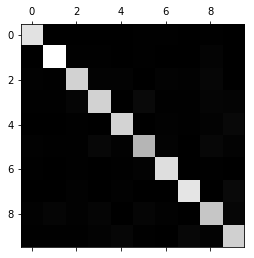

In [65]:
plt.matshow(con_mx, cmap=plt.cm.gray)
plt.show()

(5,5)가 특히 어둡다. 이는 두 가지로 해석할 수 있다. 5가 잘 분류되지 않거나, 샘플에 5의 갯수가 다른 샘플에 비해 적거나. 이런 우려를 제거하기 위해 각 클래스 갯수 별 에러 비율을 확인해보자

In [69]:
row_sums = con_mx.sum(axis=1, keepdims=True) # keepdims=True는 반환값을 열벡터로 만들어준다.
norm_con_mx = con_mx / row_sums

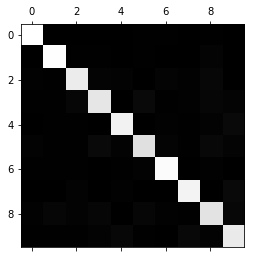

In [71]:
plt.matshow(norm_con_mx, cmap=plt.cm.gray)
plt.show() # 5가 살짝 밝아졌다.

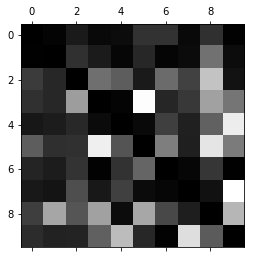

In [72]:
# 주대각선을 0으로 채워서 다른 부분의 밝기를 보자.
np.fill_diagonal(norm_con_mx, 0)
plt.matshow(norm_con_mx, cmap=plt.cm.gray)
plt.show()

8, 9 열이 밝은 것을 보아, 많은 숫자가 8, 9로 잘못 분류되고 있음을 알 수 있다. 8, 9 또한 다른 숫자로 잘못 분류되는 경우가 많다. 3과 5는 서로 혼돈되고 있다. 개개의 에러들을 그려보면 어떻게 에러를 줄일 것인지에 대한 통찰을 얻을 수도 있다.

## 다중 레이블 분류
multilabel clssification 한 샘플에 여러 개의 레이블이 있는 경우

In [9]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # 두 개의 타깃 레이블이 담긴 배열 생성.

knn_clf = KNeighborsClassifier() # KNeighborsClassifier는 다중 레이블 분류를 지원한다.
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [10]:
knn_clf.predict([some_digit]) # 두 개의 예측값이 출력.

array([[ True,  True]])

## 다중 출력 분류

노이즈가 있는 이미지를 받아, 노이즈를 제거한 이미지를 출력하는 분류기를 만들어보자. 이 분류기는 다중 출력 분류기이다. 이미지 하나 당 28x28개의 레이블이 있고(다중 레이블), 각 레이블마다 255개의 출력값이 있다(다중 출력).

In [17]:
# 우선 노이즈가 있는 이미지를 만든다. 타깃 이미지는 원본 이미지이다.
noise = np.random.randint(0, 100, (len(X_train), 784)) # (low, high=None, size=None)
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

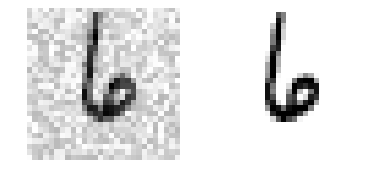

In [29]:
# 데이터와 레이블의 예
plt.subplot(121)
plt.imshow(X_train_mod[120].reshape(28,28), cmap=plt.cm.binary)
plt.axis('off')
plt.subplot(122)
plt.imshow(y_train_mod[120].reshape(28,28), cmap=plt.cm.binary)
plt.axis('off')
plt.show()

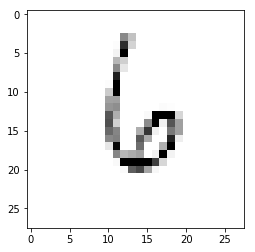

In [30]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[120]])
plt.imshow(clean_digit.reshape(28,28), cmap=plt.cm.binary)
plt.show()